(array([ 1089.,  4861., 16010., 29533., 29433., 26769., 16102.,  5293.,
          752.,   129.]),
 array([ 80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <BarContainer object of 10 artists>)

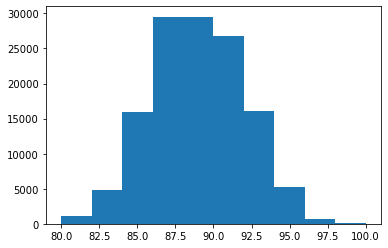

In [13]:
import pandas
from matplotlib import pyplot

wine_reviews = pandas.read_csv("../data/winemag-data-130k-v2.csv")
pyplot.hist(wine_reviews.points)

In [14]:
import re
year = []
for title in wine_reviews.title:
    year_match = re.search("(\d{4})", title)
    if year_match:
        year.append(year_match.group(1))
    else:
        year.append(None)

wine_reviews.insert(wine_reviews.shape[1], value=year, column="year")

In [15]:
# Drop incomplete data
wine_reviews.dropna(axis=0, inplace=True)

In [16]:
# Mark Catergorical Fields as such
catergorical_field = [
    "designation",
    "province",
    "region_1",
    "region_2",
    "taster_name",
    "variety",
    "winery",
    "country",
]
for field in catergorical_field:
    wine_reviews[field] = wine_reviews[field].astype('category')


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

# Train on Catergorical data only
feature = pandas.concat([wine_reviews[field].cat.codes for field in catergorical_field], axis=1)
feature.columns = catergorical_field

# Build forest
models = [
    KNeighborsClassifier(),
    LinearSVC(),
    SVC(kernal="rbf"),
    SVC(kernal="poly"),
    SVC(kernal="sigmoid"),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(hidden_layer_sizestuple=(100,), activation="relu"),
]

# Record score
for model in models:
    train_score = []
    test_score = []
    nbin_list = range(2, 20)
    for nbins in nbin_list:
        # Bin Scores into 5 bins
        labels = pandas.qcut(wine_reviews["points"], nbins, duplicates='drop').cat.codes

        # Split into Test/Train Sets
        trainX, testX, trainY, testY = train_test_split(feature, labels, test_size=0.2)

        # Train Model
        model.fit(trainX, trainY)
        train_score.append(model.score(trainX, trainY))
        test_score.append(model.score(testX, testY))

    # Create Plot
    pyplot.plot(nbin_list, train_score, label=f"Train - {model}")
    pyplot.plot(nbin_list, test_score, label=f"Test - {model}")

pyplot.legend()
pyplot.xlabel("Number of Bins for Points")
pyplot.ylabel("Model Performance")


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

# Train on Catergorical data only
feature = pandas.concat([wine_reviews[field].cat.codes for field in catergorical_field], axis=1)
feature.columns = catergorical_field

# Build forest
model = RandomForestClassifier()

# Record score
train_score = []
test_score = []
nbin_list = range(2, 20)
for nbins in nbin_list:
    # Bin Scores into 5 bins
    labels = pandas.cut(wine_reviews["points"], nbins).cat.codes

    # Split into Test/Train Sets
    trainX, testX, trainY, testY = train_test_split(feature, labels, test_size=0.2)

    # Train Model
    model.fit(trainX, trainY)
    train_score.append(model.score(trainX, trainY))
    test_score.append(model.score(testX, testY))

# Create Plot
pyplot.plot(nbin_list, train_score, label="Train")
pyplot.plot(nbin_list, test_score, label="Test")
pyplot.legend()
pyplot.xlabel("Number of Bins for Points")
pyplot.ylabel("Model Performance")
